# Exploration et transformation des données 

## Import bibliotèque 

Ce document contient les résultats de l'analyse exploratoire de données effectuée sur des données importées à partir de l'outil Stack OverFlow. 

Cette analyse a pour objectif de faciliter l'utilisation de l'outil communautaire Stack Overflow en mettant à disposition une API de suggestion de tags pour les utilisateurs.

In [1]:
import os
import warnings
warnings.filterwarnings('ignore')
import IPython.display
import numpy as np
import pandas as pd 

import seaborn as sns
from collections import defaultdict, Counter
##from nlpk_module import normalize_corpus, remove_stopwords,tok
from wordcloud import WordCloud, STOPWORDS
from nltk.corpus import stopwords
import string
import time
import lxml
import html5lib
from bs4 import BeautifulSoup

import numpy as np
import pandas as pd
pd.set_option('display.max_colwidth', 100)
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import nltk
import warnings
##import spacy
warnings.filterwarnings("ignore")

from wordcloud import WordCloud, STOPWORDS
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Tensorflow
import tensorflow as tf

In [5]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\cedri\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Milestone 1 : Récupération des questions de Stack Overflow

Dans le cadre de ce projet, nous avons utilisé une requête SQL.
Cette requête nous a permis de récupérer les différentes questions posées sur Stack Overflow.
Ces données ont été utilisées pour notre projet.

SELECT TOP(50000) Id, CreationDate, Score, ViewCount, AnswerCount, CommentCount, FavoriteCount, Title, Body, Tags

FROM Posts

WHERE CreationDate BETWEEN CONVERT(datetime, '2017-01-01') AND CONVERT(datetime, '2021-02-01')

AND Score > 5 AND AnswerCount > 0 AND LEN(Tags) - LEN(REPLACE(Tags, '<','')) >= 5

AND ViewCount > 10 AND FavoriteCount > 10

AND AnswerCount IS NOT NULL

AND CommentCount IS NOT NULL

AND FavoriteCount IS NOT NULL


ORDER BY CreationDate

## Import Data

In [6]:
path ="QueryResults 2017_2023.csv"
data = pd.read_csv(path,
                     index_col = 0,
                     parse_dates=['CreationDate'],
                     na_values = 'NaN'
                    )

In [8]:
data_origin = data.copy()
data['Body_len'] = data['Body'].apply(lambda body: len(body))

In [10]:
data.head(5)

,CreationDate,Score,ViewCount,AnswerCount,CommentCount,FavoriteCount,Title,Body,Tags,Body_len
Id,,,,,,,,,,
41413141,2017-01-01 03:25:16,6,1284,3,4,0,Why is client-side web still using an interpreted language?,<p>To my knowledge JavaScript is the only language that will execute on the client side after th...,<javascript><optimization><web><interpreted-language><compiled-language>,1196
41413489,2017-01-01 05:05:35,18,4478,1,8,0,C++1z coroutine threading context and coroutine scheduling,"<p>Per this latest C++ TS: <a href=""http://www.open-std.org/jtc1/sc22/wg21/docs/papers/2016/n462...",<c++><multithreading><async-await><coroutine><c++-coroutine>,3740
41413544,2017-01-01 05:19:20,15,36795,4,1,0,Calculate percentile from a long array?,"<p>Given a long array of latencies which are in milliseconds, I want to calculate percentile fro...",<java><math><statistics><apache-commons><percentile>,902
41414796,2017-01-01 10:29:29,25,27649,3,1,0,How to get Microsoft.Extensions.Logging<T> in console application using Serilog and AutoFac?,<p>We have common BL classes in a ASP.NET Core application that get in the ctor:</p>\n\n<p><code...,<c#><dependency-injection><asp.net-core><autofac><serilog>,548
41414838,2017-01-01 10:37:20,13,42255,3,4,0,"JQuery Datatable - Placing a custom loading GIF instead of default ""Processing"" text",<p>I'm using the current version of JQuery Datatable. I have implemented server-side processing....,<javascript><jquery><ajax><datatables><datatables-1.10>,2021


In [8]:
print(f"Il y a {data.shape[0]} Lignes dans le data set")

Il y a 42110 Lignes dans le data set


In [11]:
print(f"Il y a {data.shape[1]} colonnes dans le data set")

Il y a 9 colonnes dans le data set


In [12]:
def taux_remplissage(data):
    """
    Voir les valeurs manquantes  et le taux de remplissage des données 
    """
    var_dict = {} ## Création d'un dictionnaire permettant de stocker les 
    
    for col in data.columns:
        var_dict[col] = []
        var_dict[col].append(round((data[col].notna().sum()/data.shape[0])*100,2))
        var_dict[col].append(data[col].isna().sum())
        
    return pd.DataFrame.from_dict(data=var_dict, orient="index", columns = ["% du dataset complet", "Nombre de valeurs manquantes"]).sort_values(by="% du dataset complet", ascending=False)

In [13]:
taux_remplissage(data)

,% du dataset complet,Nombre de valeurs manquantes
CreationDate,100.0,0
Score,100.0,0
ViewCount,100.0,0
AnswerCount,100.0,0
CommentCount,100.0,0
FavoriteCount,100.0,0
Title,100.0,0
Body,100.0,0
Tags,100.0,0


On dispose de données très complètes.

In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42110 entries, 41413141 to 74012595
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   CreationDate   42110 non-null  datetime64[ns]
 1   Score          42110 non-null  int64         
 2   ViewCount      42110 non-null  int64         
 3   AnswerCount    42110 non-null  int64         
 4   CommentCount   42110 non-null  int64         
 5   FavoriteCount  42110 non-null  int64         
 6   Title          42110 non-null  object        
 7   Body           42110 non-null  object        
 8   Tags           42110 non-null  object        
dtypes: datetime64[ns](1), int64(5), object(3)
memory usage: 3.2+ MB


In [15]:
data['CreationDate'] = pd.to_datetime(data['CreationDate'])

In [16]:
data.head(5)

,CreationDate,Score,ViewCount,AnswerCount,CommentCount,FavoriteCount,Title,Body,Tags
Id,,,,,,,,,
41413141,2017-01-01 03:25:16,6,1284,3,4,0,Why is client-side web still using an interpreted language?,<p>To my knowledge JavaScript is the only language that will execute on the client side after th...,<javascript><optimization><web><interpreted-language><compiled-language>
41413489,2017-01-01 05:05:35,18,4478,1,8,0,C++1z coroutine threading context and coroutine scheduling,"<p>Per this latest C++ TS: <a href=""http://www.open-std.org/jtc1/sc22/wg21/docs/papers/2016/n462...",<c++><multithreading><async-await><coroutine><c++-coroutine>
41413544,2017-01-01 05:19:20,15,36795,4,1,0,Calculate percentile from a long array?,"<p>Given a long array of latencies which are in milliseconds, I want to calculate percentile fro...",<java><math><statistics><apache-commons><percentile>
41414796,2017-01-01 10:29:29,25,27649,3,1,0,How to get Microsoft.Extensions.Logging<T> in console application using Serilog and AutoFac?,<p>We have common BL classes in a ASP.NET Core application that get in the ctor:</p>\n\n<p><code...,<c#><dependency-injection><asp.net-core><autofac><serilog>
41414838,2017-01-01 10:37:20,13,42255,3,4,0,"JQuery Datatable - Placing a custom loading GIF instead of default ""Processing"" text",<p>I'm using the current version of JQuery Datatable. I have implemented server-side processing....,<javascript><jquery><ajax><datatables><datatables-1.10>


# Milestone 2 : Nettoyage et prétraitement des questions

On se concentre sur les colonnes "Title" et "Body".

In [17]:
colonne_str = [
               "Title",
               "Body"
                ]

In [18]:
data = data.reset_index()

## Conversion en minucscule 

Les colonnes ont été converties en minuscules afin d'éviter des problèmes de traitement liés à l'utilisation des variables.

In [19]:
data [colonne_str] = data[colonne_str].apply(lambda x:  x.astype(str).str.lower())

In [20]:
data.head(4)

,Id,CreationDate,Score,ViewCount,AnswerCount,CommentCount,FavoriteCount,Title,Body,Tags
0,41413141,2017-01-01 03:25:16,6,1284,3,4,0,why is client-side web still using an interpreted language?,<p>to my knowledge javascript is the only language that will execute on the client side after th...,<javascript><optimization><web><interpreted-language><compiled-language>
1,41413489,2017-01-01 05:05:35,18,4478,1,8,0,c++1z coroutine threading context and coroutine scheduling,"<p>per this latest c++ ts: <a href=""http://www.open-std.org/jtc1/sc22/wg21/docs/papers/2016/n462...",<c++><multithreading><async-await><coroutine><c++-coroutine>
2,41413544,2017-01-01 05:19:20,15,36795,4,1,0,calculate percentile from a long array?,"<p>given a long array of latencies which are in milliseconds, i want to calculate percentile fro...",<java><math><statistics><apache-commons><percentile>
3,41414796,2017-01-01 10:29:29,25,27649,3,1,0,how to get microsoft.extensions.logging<t> in console application using serilog and autofac?,<p>we have common bl classes in a asp.net core application that get in the ctor:</p>\n\n<p><code...,<c#><dependency-injection><asp.net-core><autofac><serilog>


## Remove HTML 

À cette étape, l'objectif est de supprimer le formatage HTML dans les questions et les corps de texte des posts de Stack Overflow.

In [21]:
def clean_html(text):
    """
    Remove HTML from a text.
    
    Args:
        text(String): Row text with html 
             
    Returns:
        cleaned String
    """
    import lxml
    import html5lib
    from bs4 import BeautifulSoup
 
    soup = BeautifulSoup(text, "html5lib")

    for sent in soup(['style', 'script']):
            sent.decompose()
   
        
    return ' '.join(soup.stripped_strings)

training_start = time.perf_counter()

for col in colonne_str :
    data [col] = [clean_html(text) for text in data [col]]
    
training_end = time.perf_counter() 
print("le temps de l'étape est de", training_end - training_start,"s" ) 

le temps de l'étape est de 90.54468409999936 s


In [22]:
data.head(2)

,Id,CreationDate,Score,ViewCount,AnswerCount,CommentCount,FavoriteCount,Title,Body,Tags
0,41413141,2017-01-01 03:25:16,6,1284,3,4,0,why is client-side web still using an interpreted language?,to my knowledge javascript is the only language that will execute on the client side after the h...,<javascript><optimization><web><interpreted-language><compiled-language>
1,41413489,2017-01-01 05:05:35,18,4478,1,8,0,c++1z coroutine threading context and coroutine scheduling,"per this latest c++ ts: http://www.open-std.org/jtc1/sc22/wg21/docs/papers/2016/n4628.pdf , and ...",<c++><multithreading><async-await><coroutine><c++-coroutine>


##  Punction 

À cette étape, on élimine les caractères de ponctuation de chaque phrase.

In [23]:
%%time

def text_cleaning(text):
    """
    Remove figures, punctuation, words shorter than two letters (excepted C or R) in a lowered text. 
    
    Args:
        text(String): Row text to clean
        
    Returns:
       res(string): Cleaned text
    """
    import re
    
    pattern = re.compile(r'[^\w]|[\d_]')
    
    try: 
        res = re.sub(pattern," ", text).lower()
    except TypeError:
        return text
    
    res = res.split(" ")
    res = list(filter(lambda x: len(x)>3 , res))
    res = " ".join(res)
    return res

data ["Title Clean"] = [text_cleaning(text) for text in  data ["Title"]]
data ["Body Clean"] = [text_cleaning(text).strip() for text in data ["Body"]]
data ["Tags Clean"] = [text_cleaning(text).strip() for text in data ["Tags"]]


Wall time: 9.42 s


In [23]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [24]:
data ["Body Clean"] 

0        knowledge javascript only language that will execute client side after html file been retrieved ...
1        this latest http open docs papers based understanding async await language support wondering wha...
2        given long array latencies which milliseconds want calculate percentile from them below method w...
3        have common classes core application that ctor microsoft extensions logging ilogger core interna...
4        using current version jquery datatable have implemented server side processing there place loadi...
                                                        ...                                                 
42105    include iostream main bool true cout same decltype bool value auto cout same decltype bool value...
42106    trying upgrade legacy mail authenticate oauth instead basic authentication deprecated days from ...
42107    while looking code dear imgui found following code edited relevance struct imvec float float ope...
42108    trying jen

In [25]:
data.head(2)

,Id,CreationDate,Score,ViewCount,AnswerCount,CommentCount,FavoriteCount,Title,Body,Tags,Title Clean,Body Clean,Tags Clean
0,41413141,2017-01-01 03:25:16,6,1284,3,4,0,why is client-side web still using an interpreted language?,to my knowledge javascript is the only language that will execute on the client side after the h...,<javascript><optimization><web><interpreted-language><compiled-language>,client side still using interpreted language,knowledge javascript only language that will execute client side after html file been retrieved ...,javascript optimization interpreted language compiled language
1,41413489,2017-01-01 05:05:35,18,4478,1,8,0,c++1z coroutine threading context and coroutine scheduling,"per this latest c++ ts: http://www.open-std.org/jtc1/sc22/wg21/docs/papers/2016/n4628.pdf , and ...",<c++><multithreading><async-await><coroutine><c++-coroutine>,coroutine threading context coroutine scheduling,this latest http open docs papers based understanding async await language support wondering wha...,multithreading async await coroutine coroutine


In [26]:
colonne_str = ["Title Clean","Body Clean"]

In [27]:
data [colonne_str].head(5)

,Title Clean,Body Clean
0,client side still using interpreted language,knowledge javascript only language that will execute client side after html file been retrieved ...
1,coroutine threading context coroutine scheduling,this latest http open docs papers based understanding async await language support wondering wha...
2,calculate percentile from long array,given long array latencies which milliseconds want calculate percentile from them below method w...
3,microsoft extensions logging console application using serilog autofac,have common classes core application that ctor microsoft extensions logging ilogger core interna...
4,jquery datatable placing custom loading instead default processing text,using current version jquery datatable have implemented server side processing there place loadi...


## Caractères supplémentaires dans la colonne tag.

À cette étape, l'objectif est de supprimer les caractères HTML des tags. Cependant, lors de nos premiers essais en utilisant une fonction qui supprime les saisies HTML, nous avons rencontré un problème. 

En effet, cette fonction supprimait tout, y compris le contenu des tags, ce qui nous laissait avec des tags vides. Pour remédier à ce problème, nous avons dû trouver une autre méthode pour supprimer uniquement les caractères HTML dans les tags sans affecter leur contenu.

In [32]:
# Processing tags
data["Tags Clean"] = data["Tags"].replace({"<" : " "},
                                     regex=True)
data["Tags Clean"] = data["Tags"].replace({">" : ","},
                                     regex=True)
data["Tags Clean"] = data["Tags"].str.rstrip(',')

In [33]:
data.head(2)

,Id,CreationDate,Score,ViewCount,AnswerCount,CommentCount,FavoriteCount,Title,Body,Tags,Title Clean,Body Clean,Tags Clean
0,41413141,2017-01-01 03:25:16,6,1284,3,4,0,why is client-side web still using an interpreted language?,to my knowledge javascript is the only language that will execute on the client side after the h...,<javascript><optimization><web><interpreted-language><compiled-language>,client side still using interpreted language,knowledge javascript only language that will execute client side after html file been retrieved ...,<javascript><optimization><web><interpreted-language><compiled-language>
1,41413489,2017-01-01 05:05:35,18,4478,1,8,0,c++1z coroutine threading context and coroutine scheduling,"per this latest c++ ts: http://www.open-std.org/jtc1/sc22/wg21/docs/papers/2016/n4628.pdf , and ...",<c++><multithreading><async-await><coroutine><c++-coroutine>,coroutine threading context coroutine scheduling,this latest http open docs papers based understanding async await language support wondering wha...,<c++><multithreading><async-await><coroutine><c++-coroutine>


## Tokenize

A cette étape, nous utilisons une fonction pour découper les variables en "tokens". Cette fonction utilise le module "tokenize" de Python qui permet de scanner le code source et de récupérer les commentaires sous forme de "jetons". 

Cette fonction est utile pour créer des listes qui peuvent être prise en compte dans le modèle.

In [35]:
data [colonne_str].head(2)

,Title Clean,Body Clean
0,client side still using interpreted language,knowledge javascript only language that will execute client side after html file been retrieved ...
1,coroutine threading context coroutine scheduling,this latest http open docs papers based understanding async await language support wondering wha...


In [37]:
data.head(1)

,Id,CreationDate,Score,ViewCount,AnswerCount,CommentCount,FavoriteCount,Title,Body,Tags,Title Clean,Body Clean,Tags Clean,Title Clean WC,Tags Clean WC,Body Clean WC
0,41413141,2017-01-01 03:25:16,6,1284,3,4,0,why is client-side web still using an interpreted language?,to my knowledge javascript is the only language that will execute on the client side after the h...,<javascript><optimization><web><interpreted-language><compiled-language>,client side still using interpreted language,knowledge javascript only language that will execute client side after html file been retrieved ...,<javascript><optimization><web><interpreted-language><compiled-language>,client side still using interpreted language,<javascript><optimization><web><interpreted-language><compiled-language>,knowledge javascript only language that will execute client side after html file been retrieved ...


Nous avons débuté en initialisant les "stopwords" que nous souhaitons retirer des colonnes. Cette étape est effectuée simultanément à la tokenization, car nous souhaitons enlever les mots qui pourraient influencer le résultat de l'analyse.

In [39]:
nltk.download('stopwords')
stopword = nltk.corpus.stopwords.words('english')
stopword.extend(re.split('\W+', "https"))
numbers = np.arange(9999)
number_add = ["01","02","03","04","05","06","07","08","09"]
for i in numbers :
    stopword.extend(re.split('\W+', str(i)))

for i in number_add :
    stopword.extend(re.split('\W+', str(i)))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\cedri\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [42]:
%%time
def tokenize(text):
    """
    Tokenize words of a text.
    
    Args:
    
        text(String): Row text
        
    Returns
    
        res(list): Tokenized string.
    """
    
    try:
        res = word_tokenize(text, language='english')
    except TypeError:
        return text
    
    res = [token for token in res if token not in stopword]
    return res

training_start = time.perf_counter()

data["Title Clean Tk"] = [tokenize(text) for text in data['Title Clean'].to_list()]
data["Body Clean Tk"] = [tokenize(text) for text in data['Body Clean'].to_list()]
data["Tags Clean Tk"] = [tokenize(text) for text in data['Tags Clean'].to_list()]

training_end = time.perf_counter() 
print("le temps de l'étape est de", training_end - training_start,"s" )

le temps de l'étape est de 747.6599692 s
Wall time: 12min 27s


## Size Word

À cette étape, nous éliminons les mots qui contiennent plus de 21 caractères.

In [43]:
def remove_stopword(tokenize_list):
    
    text = [word for word in tokenize_list if (len(word)>2 and len(word) < 21)]
    clean_text = text.copy()
    
    return clean_text

In [45]:
training_start = time.perf_counter()

data ["Title Clean Tk SW"] = data["Title Clean Tk"].apply(lambda text : remove_stopword(text))

training_end = time.perf_counter() 
print("le temps de l'étape est de", training_end - training_start,"s" )

le temps de l'étape est de 0.062075199999526376 s


In [46]:
data ["Title Clean Tk SW"]

0                                      [client, side, still, using, interpreted, language]
1                                   [coroutine, threading, context, coroutine, scheduling]
2                                                     [calculate, percentile, long, array]
3          [microsoft, extensions, logging, console, application, using, serilog, autofac]
4        [jquery, datatable, placing, custom, loading, instead, default, processing, text]
                                               ...                                        
42105                                                      [different, results, compilers]
42106                         [office, imap, authentication, oauth, python, msal, library]
42107                            [valid, treat, scalar, members, struct, comprised, array]
42108                                   [jenkins, deploying, latest, github, commit, code]
42109                   [code, throws, recursionerror, expected, throw, earlier, versions]

In [47]:
training_start = time.perf_counter()

data ["Body Clean Tk SW"] = data["Body Clean Tk"].apply(lambda text : remove_stopword(text))


training_end = time.perf_counter() 
print("le temps de l'étape est de", training_end - training_start,"s" )

le temps de l'étape est de 1.0860291999997571 s


In [48]:
data ["Body Clean Tk SW"]

0        [knowledge, javascript, language, execute, client, side, html, file, retrieved, server, know, ja...
1        [latest, http, open, docs, papers, based, understanding, async, await, language, support, wonder...
2        [given, long, array, latencies, milliseconds, want, calculate, percentile, method, work, sure, v...
3        [common, classes, core, application, ctor, microsoft, extensions, logging, ilogger, core, intern...
4        [using, current, version, jquery, datatable, implemented, server, side, processing, place, loadi...
                                                        ...                                                 
42105    [include, iostream, main, bool, true, cout, decltype, bool, value, auto, cout, decltype, bool, v...
42106    [trying, upgrade, legacy, mail, authenticate, oauth, instead, basic, authentication, deprecated,...
42107    [looking, code, dear, imgui, found, following, code, edited, relevance, struct, imvec, float, fl...
42108    [trying, j

data [colonne_str] = data [colonne_str].apply(lambda text : remove_stopword(text))

In [49]:
training_start = time.perf_counter()

data ["Tags Clean Tk SW"] = data["Tags Clean Tk"].apply(lambda text : remove_stopword(text))


training_end = time.perf_counter() 
print("le temps de l'étape est de", training_end - training_start,"s" )

le temps de l'étape est de 0.08390010000039183 s


In [50]:
data ["Tags Clean Tk SW"]

0        [javascript, optimization, web, interpreted-language, compiled-language]
1                    [c++, multithreading, async-await, coroutine, c++-coroutine]
2                            [java, math, statistics, apache-commons, percentile]
3                          [dependency-injection, asp.net-core, autofac, serilog]
4                         [javascript, jquery, ajax, datatables, datatables-1.10]
                                           ...                                   
42105                            [c++, boolean, rvalue, lvalue, value-categories]
42106                                 [python, email, oauth-2.0, office365, imap]
42107                [c++, pointers, struct, undefined-behavior, strict-aliasing]
42108                                           [.net, jenkins, deployment, cicd]
42109          [python, recursion, stack-overflow, try-except, pythoninterpreter]
Name: Tags Clean Tk SW, Length: 42110, dtype: object

## Lemmization

À cette étape, l'objectif est de conserver le radical de chaque mot.

In [51]:
nltk.download('wordnet')
wn = nltk.WordNetLemmatizer()

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\cedri\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [52]:
def lemmatize(tokenize_word):
    text = [wn.lemmatize(word) for word in tokenize_word]
    return text

In [53]:
data[["Body Clean Tk SW","Title Clean Tk SW"]]

,Body Clean Tk SW,Title Clean Tk SW
0,"[knowledge, javascript, language, execute, client, side, html, file, retrieved, server, know, ja...","[client, side, still, using, interpreted, language]"
1,"[latest, http, open, docs, papers, based, understanding, async, await, language, support, wonder...","[coroutine, threading, context, coroutine, scheduling]"
2,"[given, long, array, latencies, milliseconds, want, calculate, percentile, method, work, sure, v...","[calculate, percentile, long, array]"
3,"[common, classes, core, application, ctor, microsoft, extensions, logging, ilogger, core, intern...","[microsoft, extensions, logging, console, application, using, serilog, autofac]"
4,"[using, current, version, jquery, datatable, implemented, server, side, processing, place, loadi...","[jquery, datatable, placing, custom, loading, instead, default, processing, text]"
...,...,...
42105,"[include, iostream, main, bool, true, cout, decltype, bool, value, auto, cout, decltype, bool, v...","[different, results, compilers]"
42106,"[trying, upgrade, legacy, mail, authenticate, oauth, instead, basic, authentication, deprecated,...","[office, imap, authentication, oauth, python, msal, library]"
42107,"[looking, code, dear, imgui, found, following, code, edited, relevance, struct, imvec, float, fl...","[valid, treat, scalar, members, struct, comprised, array]"
42108,"[trying, jenkins, deploy, latest, code, github, branch, server, push, release, branch, however, ...","[jenkins, deploying, latest, github, commit, code]"


In [54]:
data["Body Clean Tk SW"]

0        [knowledge, javascript, language, execute, client, side, html, file, retrieved, server, know, ja...
1        [latest, http, open, docs, papers, based, understanding, async, await, language, support, wonder...
2        [given, long, array, latencies, milliseconds, want, calculate, percentile, method, work, sure, v...
3        [common, classes, core, application, ctor, microsoft, extensions, logging, ilogger, core, intern...
4        [using, current, version, jquery, datatable, implemented, server, side, processing, place, loadi...
                                                        ...                                                 
42105    [include, iostream, main, bool, true, cout, decltype, bool, value, auto, cout, decltype, bool, v...
42106    [trying, upgrade, legacy, mail, authenticate, oauth, instead, basic, authentication, deprecated,...
42107    [looking, code, dear, imgui, found, following, code, edited, relevance, struct, imvec, float, fl...
42108    [trying, j

In [55]:
training_start = time.perf_counter()

data["Body"] = data["Body Clean Tk SW"] .apply(lambda x : lemmatize(x))

training_end = time.perf_counter() 
print("le temps de l'étape est de", training_end - training_start,"s" )


le temps de l'étape est de 21.548851500000637 s


In [56]:
data["Body"]

0        [knowledge, javascript, language, execute, client, side, html, file, retrieved, server, know, ja...
1        [latest, http, open, doc, paper, based, understanding, async, await, language, support, wonderin...
2        [given, long, array, latency, millisecond, want, calculate, percentile, method, work, sure, veri...
3        [common, class, core, application, ctor, microsoft, extension, logging, ilogger, core, internal,...
4        [using, current, version, jquery, datatable, implemented, server, side, processing, place, loadi...
                                                        ...                                                 
42105    [include, iostream, main, bool, true, cout, decltype, bool, value, auto, cout, decltype, bool, v...
42106    [trying, upgrade, legacy, mail, authenticate, oauth, instead, basic, authentication, deprecated,...
42107    [looking, code, dear, imgui, found, following, code, edited, relevance, struct, imvec, float, fl...
42108    [trying, j

In [57]:
training_start = time.perf_counter()

data["Title"] = data["Title Clean Tk SW"] .apply(lambda x : lemmatize(x))


training_end = time.perf_counter() 
print("le temps de l'étape est de", training_end - training_start,"s" )

le temps de l'étape est de 1.0785087999993266 s


In [58]:
data["Title"] 

0                                      [client, side, still, using, interpreted, language]
1                                   [coroutine, threading, context, coroutine, scheduling]
2                                                     [calculate, percentile, long, array]
3           [microsoft, extension, logging, console, application, using, serilog, autofac]
4        [jquery, datatable, placing, custom, loading, instead, default, processing, text]
                                               ...                                        
42105                                                        [different, result, compiler]
42106                         [office, imap, authentication, oauth, python, msal, library]
42107                             [valid, treat, scalar, member, struct, comprised, array]
42108                                   [jenkins, deploying, latest, github, commit, code]
42109                     [code, throw, recursionerror, expected, throw, earlier, version]

In [59]:
training_start = time.perf_counter()

data["Tags"] = data["Tags Clean Tk SW"] .apply(lambda x : lemmatize(x))


training_end = time.perf_counter() 
print("le temps de l'étape est de", training_end - training_start,"s" )


le temps de l'étape est de 1.2170687999996517 s


for col in colonne_str :
    data[col] = data[col].apply(lambda x : lemmatize(x))

In [60]:
data.head(5)

,Id,CreationDate,Score,ViewCount,AnswerCount,CommentCount,FavoriteCount,Title,Body,Tags,...,Tags Clean,Title Clean WC,Tags Clean WC,Body Clean WC,Title Clean Tk,Body Clean Tk,Tags Clean Tk,Title Clean Tk SW,Body Clean Tk SW,Tags Clean Tk SW
0,41413141,2017-01-01 03:25:16,6,1284,3,4,0,"[client, side, still, using, interpreted, language]","[knowledge, javascript, language, execute, client, side, html, file, retrieved, server, know, ja...","[javascript, optimization, web, interpreted-language, compiled-language]",...,<javascript><optimization><web><interpreted-language><compiled-language>,client side still using interpreted language,<javascript><optimization><web><interpreted-language><compiled-language>,knowledge javascript only language that will execute client side after html file been retrieved ...,"[client, side, still, using, interpreted, language]","[knowledge, javascript, language, execute, client, side, html, file, retrieved, server, know, ja...","[<, javascript, >, <, optimization, >, <, web, >, <, interpreted-language, >, <, compiled-langua...","[client, side, still, using, interpreted, language]","[knowledge, javascript, language, execute, client, side, html, file, retrieved, server, know, ja...","[javascript, optimization, web, interpreted-language, compiled-language]"
1,41413489,2017-01-01 05:05:35,18,4478,1,8,0,"[coroutine, threading, context, coroutine, scheduling]","[latest, http, open, doc, paper, based, understanding, async, await, language, support, wonderin...","[c++, multithreading, async-await, coroutine, c++-coroutine]",...,<c++><multithreading><async-await><coroutine><c++-coroutine>,coroutine threading context coroutine scheduling,<c++><multithreading><async-await><coroutine><c++-coroutine>,this latest http open docs papers based understanding async await language support wondering wha...,"[coroutine, threading, context, coroutine, scheduling]","[latest, http, open, docs, papers, based, understanding, async, await, language, support, wonder...","[<, c++, >, <, multithreading, >, <, async-await, >, <, coroutine, >, <, c++-coroutine, >]","[coroutine, threading, context, coroutine, scheduling]","[latest, http, open, docs, papers, based, understanding, async, await, language, support, wonder...","[c++, multithreading, async-await, coroutine, c++-coroutine]"
2,41413544,2017-01-01 05:19:20,15,36795,4,1,0,"[calculate, percentile, long, array]","[given, long, array, latency, millisecond, want, calculate, percentile, method, work, sure, veri...","[java, math, statistic, apache-commons, percentile]",...,<java><math><statistics><apache-commons><percentile>,calculate percentile from long array,<java><math><statistics><apache-commons><percentile>,given long array latencies which milliseconds want calculate percentile from them below method w...,"[calculate, percentile, long, array]","[given, long, array, latencies, milliseconds, want, calculate, percentile, method, work, sure, v...","[<, java, >, <, math, >, <, statistics, >, <, apache-commons, >, <, percentile, >]","[calculate, percentile, long, array]","[given, long, array, latencies, milliseconds, want, calculate, percentile, method, work, sure, v...","[java, math, statistics, apache-commons, percentile]"
3,41414796,2017-01-01 10:29:29,25,27649,3,1,0,"[microsoft, extension, logging, console, application, using, serilog, autofac]","[common, class, core, application, ctor, microsoft, extension, logging, ilogger, core, internal,...","[dependency-injection, asp.net-core, autofac, serilog]",...,<c#><dependency-injection><asp.net-core><autofac><serilog>,microsoft extensions logging console application using serilog autofac,<c#><dependency-injection><asp.net-core><autofac><serilog>,have common classes core application that ctor microsoft extensions logging ilogger core interna...,"[microsoft, extensions, logging, console, application, using, serilog, autofac]","[common, classes, core, application, ctor, microsoft, extensions, logging, ilogger, core, intern...","[<, c, #, 

In [64]:
def token_to_normal(text):
    """
    Token to Normal
    """
    new_text = ""
    
    for word in text :
        new_text = new_text + " " + word

    return new_text

In [65]:
data ["Title T2N"] = data ["Title"].apply(lambda x : token_to_normal(x))
data ["Tags T2N"] = data ["Tags"].apply(lambda x : token_to_normal(x))
data ["Body T2N"] = data ["Body"].apply(lambda x : token_to_normal(x))

In [66]:
colonnes = ["Id","Title","Body","Tags","Title T2N","Tags T2N","Body T2N"]

In [67]:
data = data[colonnes]

In [68]:
data.head(5)

,Id,Title,Body,Tags,Title T2N,Tags T2N,Body T2N
0,41413141,"[client, side, still, using, interpreted, language]","[knowledge, javascript, language, execute, client, side, html, file, retrieved, server, know, ja...","[javascript, optimization, web, interpreted-language, compiled-language]",client side still using interpreted language,javascript optimization web interpreted-language compiled-language,knowledge javascript language execute client side html file retrieved server know javascript me...
1,41413489,"[coroutine, threading, context, coroutine, scheduling]","[latest, http, open, doc, paper, based, understanding, async, await, language, support, wonderin...","[c++, multithreading, async-await, coroutine, c++-coroutine]",coroutine threading context coroutine scheduling,c++ multithreading async-await coroutine c++-coroutine,latest http open doc paper based understanding async await language support wondering execution...
2,41413544,"[calculate, percentile, long, array]","[given, long, array, latency, millisecond, want, calculate, percentile, method, work, sure, veri...","[java, math, statistic, apache-commons, percentile]",calculate percentile long array,java math statistic apache-commons percentile,given long array latency millisecond want calculate percentile method work sure verify whether ...
3,41414796,"[microsoft, extension, logging, console, application, using, serilog, autofac]","[common, class, core, application, ctor, microsoft, extension, logging, ilogger, core, internal,...","[dependency-injection, asp.net-core, autofac, serilog]",microsoft extension logging console application using serilog autofac,dependency-injection asp.net-core autofac serilog,common class core application ctor microsoft extension logging ilogger core internal infrastruc...
4,41414838,"[jquery, datatable, placing, custom, loading, instead, default, processing, text]","[using, current, version, jquery, datatable, implemented, server, side, processing, place, loadi...","[javascript, jquery, ajax, datatables, datatables-1.10]",jquery datatable placing custom loading instead default processing text,javascript jquery ajax datatables datatables-1.10,using current version jquery datatable implemented server side processing place loading instead...


In [69]:
data.to_excel("output.xlsx") 

## World Cloud generator

Dans cette étape, nous cherchons à identifier les mots les plus fréquemment utilisés dans nos variables.

In [70]:
def wordCloud_generator(data, title=None):
    import matplotlib.pyplot as plt
    wordcloud = WordCloud(width = 800, height = 800,
                          background_color ='black',
                          min_font_size = 10
                         ).generate(" ".join(data.values))                      
    plt.figure(figsize = (8, 8), facecolor = None) 
    plt.imshow(wordcloud, interpolation='bilinear') 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.title(title,fontsize=30)
    plt.show()

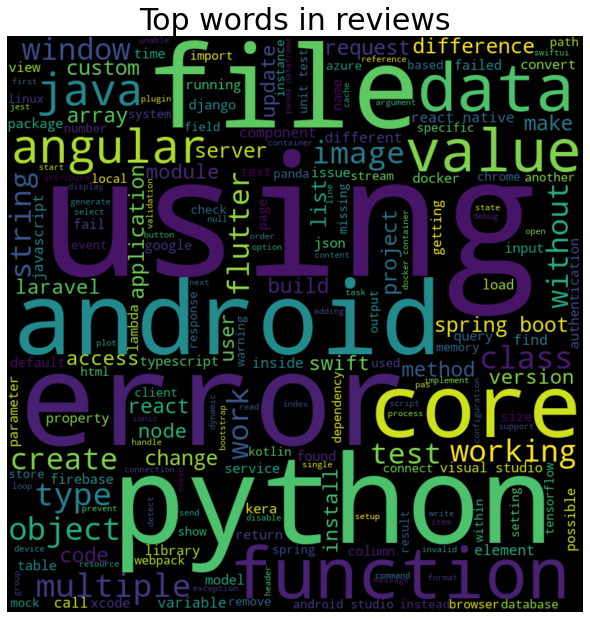

In [71]:
wordCloud_generator(data ["Title T2N"], title="Top words in reviews")

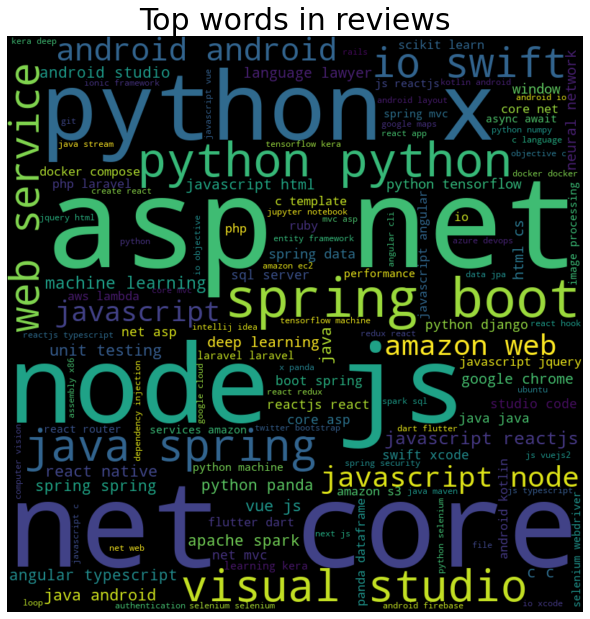

In [72]:
wordCloud_generator(data ["Tags T2N"] , title="Top words in reviews")

# Analyse exploratoire

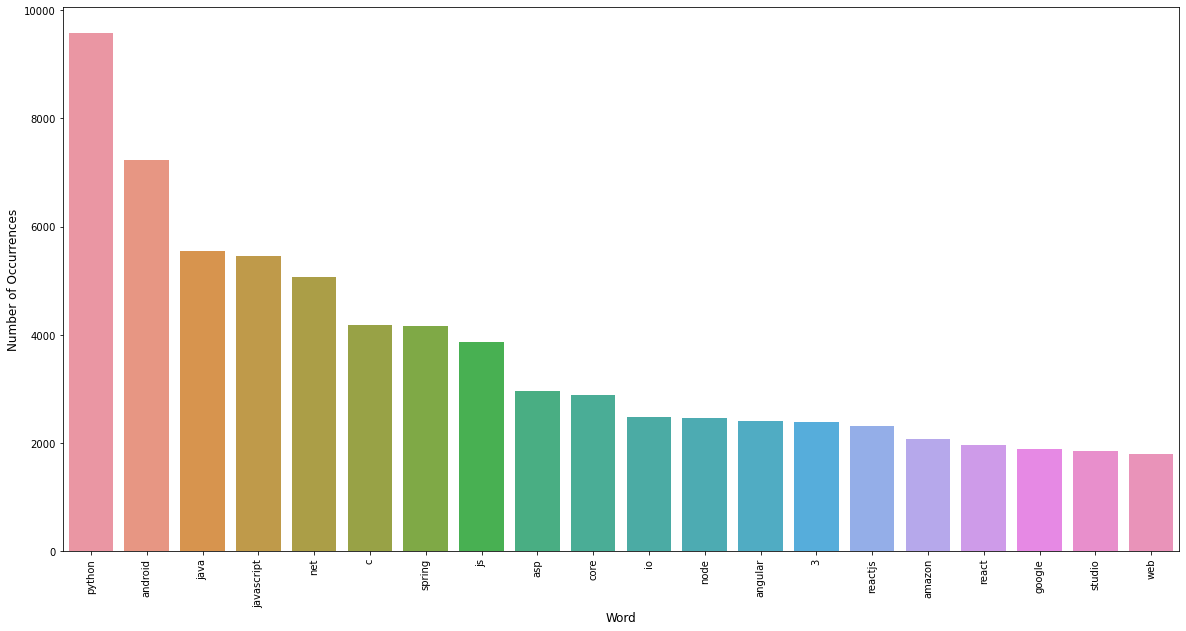

In [73]:
counts = data["Tags T2N"].str.findall(r"(\w+)").explode().value_counts()[:20]
fig, ax = plt.subplots(figsize=(20,10))
sns.barplot(x=counts.index, y=counts.values, ax=ax)
ax.set_ylabel('Number of Occurrences', fontsize=12)
ax.set_xlabel('Word', fontsize=12)
ax.xaxis.set_tick_params(rotation=90)

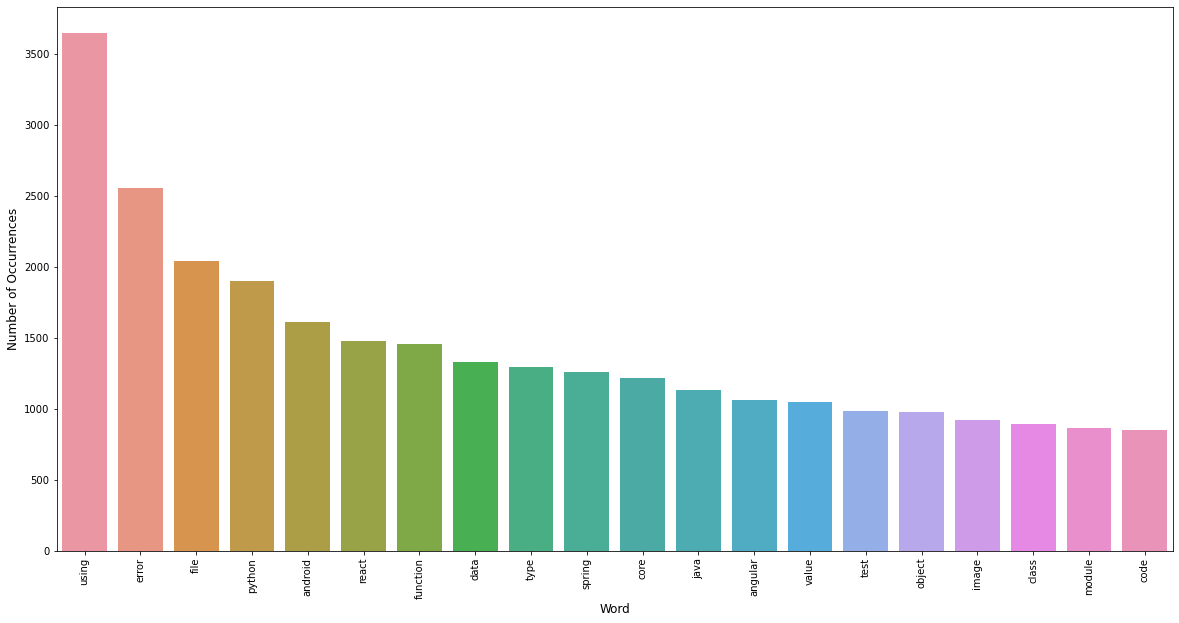

In [74]:
counts = data["Title T2N"].str.findall(r"(\w+)").explode().value_counts()[:20]
fig, ax = plt.subplots(figsize=(20,10))
sns.barplot(x=counts.index, y=counts.values, ax=ax)
ax.set_ylabel('Number of Occurrences', fontsize=12)
ax.set_xlabel('Word', fontsize=12)
ax.xaxis.set_tick_params(rotation=90)

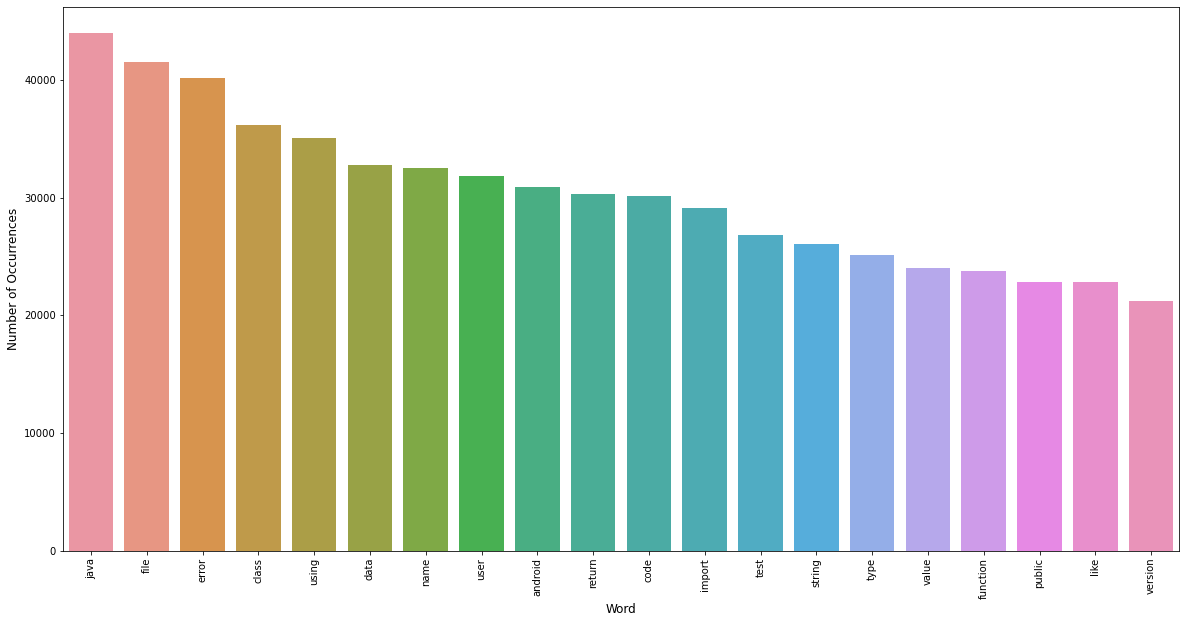

In [75]:
counts = data["Body T2N"].str.findall(r"(\w+)").explode().value_counts()[:20]
fig, ax = plt.subplots(figsize=(20,10))
sns.barplot(x=counts.index, y=counts.values, ax=ax)
ax.set_ylabel('Number of Occurrences', fontsize=12)
ax.set_xlabel('Word', fontsize=12)
ax.xaxis.set_tick_params(rotation=90)

In [76]:
data['Title_len'] = data['Title'].apply(lambda title: len(title))
data['Body_len'] = data['Body'].apply(lambda body: len(body))

<AxesSubplot:>

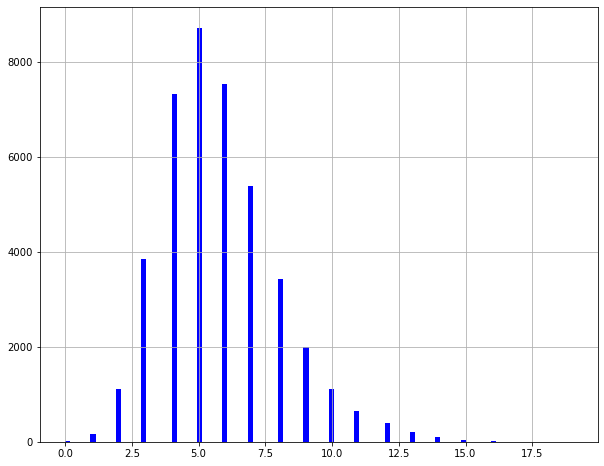

In [77]:
data['Title_len'].hist(bins=100, figsize=(10, 8), color = "b")

En analysant les données, nous avons constaté que la plupart des titres de questions étaient composés de 5 mots en moyenne. 
Nous avons également observé que la distribution des longueurs de titres suivait une loi normale.

<AxesSubplot:>

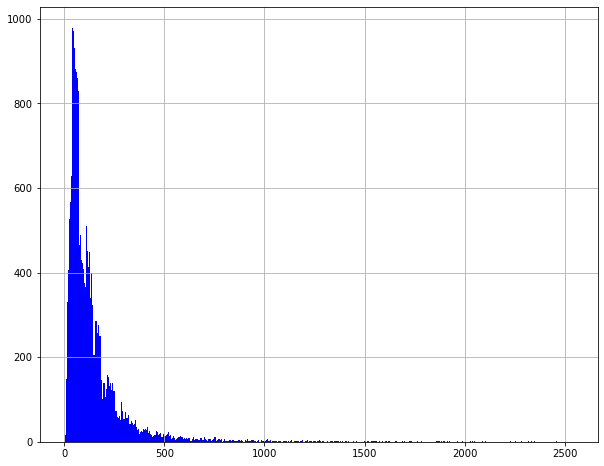

In [78]:
data['Body_len'].hist(bins=1000, figsize=(10, 8), color = "b")

# Vectorization

In [80]:
taux_remplissage(data)

,% du dataset complet,Nombre de valeurs manquantes
Id,100.0,0
Title,100.0,0
Body,100.0,0
Tags,100.0,0
Title T2N,100.0,0
Tags T2N,100.0,0
Body T2N,100.0,0
Title_len,100.0,0
Body_len,100.0,0


In [81]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
vectorizer = CountVectorizer(max_features=2000)
bow_title = vectorizer.fit_transform(data["Title T2N"]).toarray()
df_title = pd.DataFrame(bow_title, columns=vectorizer.get_feature_names_out())
df_title_freq = pd.DataFrame(df_title.sum(), columns=["Value"])
df_title_freq.sort_values(by=['Value'], inplace=True,ascending=False)
df_title_freq.head()

,Value
using,3651
error,2556
file,2041
python,1904
android,1616


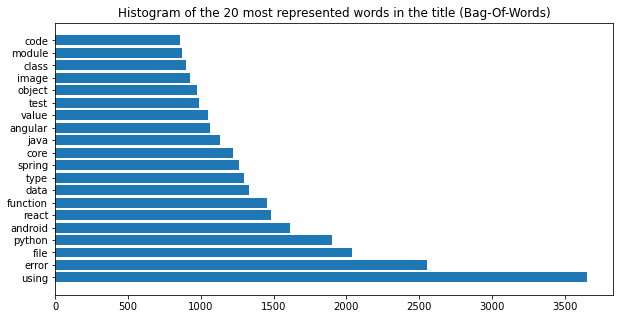

In [82]:
top_20_title_word = df_title_freq.sort_values("Value", ascending=False)[:20]

plt.figure(figsize=(10,5))
plt.barh(y=top_20_title_word.index, width=top_20_title_word.Value)
plt.title("Histogram of the 20 most represented words in the title (Bag-Of-Words)")
plt.show()

In [83]:
vectorizer_tf = TfidfVectorizer(max_features=2000)
tfidf_title = vectorizer_tf.fit_transform(data['Title T2N']).toarray()
feature_names = vectorizer_tf.get_feature_names_out()
df_title_tf = pd.DataFrame(tfidf_title, columns=feature_names)
df_title_tf_freq = pd.DataFrame(df_title_tf.sum(), columns=["Value"])
df_title_tf_freq.sort_values(by=['Value'], inplace=True,ascending=False)
df_title_tf_freq

,Value
using,912.869175
error,666.442210
python,602.841776
file,597.622796
android,506.082094
...,...
convolutional,8.465918
currently,8.448481
rather,8.377090
smtp,8.108176


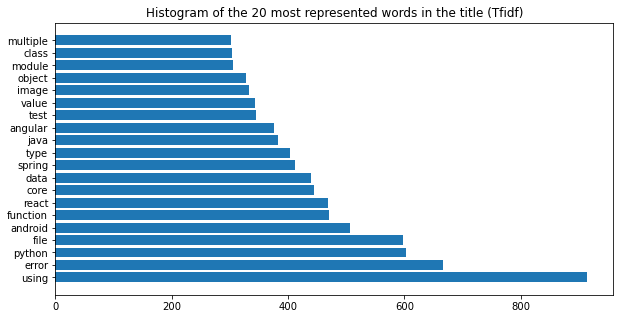

In [84]:
top_20_title_word_tf = df_title_tf_freq.sort_values("Value",ascending=False)[:20]

plt.figure(figsize=(10,5))
plt.barh(y=top_20_title_word_tf.index, width=top_20_title_word_tf.Value)
plt.title("Histogram of the 20 most represented words in the title (Tfidf)")
plt.show()

In [85]:
vectorizer = CountVectorizer(max_features=2000)
bow_body = vectorizer.fit_transform(data["Body T2N"]).toarray()
df_body = pd.DataFrame(bow_body, columns=vectorizer.get_feature_names_out())
df_body_freq = pd.DataFrame(df_body.sum(), columns=["Value"])
df_body_freq.sort_values(by=['Value'], inplace=True,ascending=False)
df_body_freq.head(2000)

,Value
java,43985
file,41497
error,40143
class,36205
using,35064
...,...
geom,357
blocked,357
adam,357
priority,356


In [86]:
df_body 

,able,absolute,abstract,abstractbeanfactory,accept,accepted,access,accessing,according,account,...,xdebug,xmlns,yaml,yarn,year,yield,youtube,zero,zone,zygoteinit
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42105,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
42106,1,0,0,0,0,0,6,0,0,1,...,0,0,0,0,0,0,0,0,0,0
42107,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
42108,0,0,0,0,0,0,0,0,0,3,...,0,0,0,0,0,0,0,0,0,0


In [87]:
vectorizer = CountVectorizer(max_features=1000)
bow_body = vectorizer.fit_transform(data["Body T2N"]).toarray()
df_body = pd.DataFrame(bow_body, columns=vectorizer.get_feature_names_out())
df_body_freq = pd.DataFrame(df_body.sum(), columns=["Value"])
df_body_freq.sort_values(by=['Value'], inplace=True,ascending=False)
df_body_freq.head()

,Value
java,43985
file,41497
error,40143
class,36205
using,35064


In [88]:
vectorizer_tf = TfidfVectorizer(max_features=2000)
tfidf_body = vectorizer_tf.fit_transform(data['Body T2N']).toarray()
feature_names = vectorizer_tf.get_feature_names_out()
df_body_tf = pd.DataFrame(tfidf_body, columns=feature_names)
df_body_tf_freq = pd.DataFrame(df_body_tf.sum(), columns=["Value"])
df_body_tf_freq.sort_values(by=['Value'], inplace=True,ascending=False)
df_body_tf_freq.head(10)

,Value
file,1121.954922
error,1031.059495
data,965.123472
using,955.509986
class,930.006841
user,869.664903
code,836.442253
string,828.570568
import,820.647785
test,810.033912


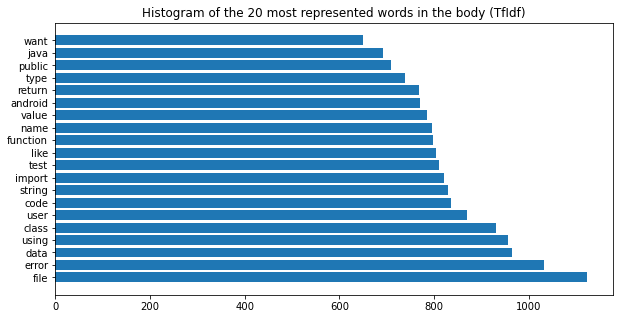

In [89]:
top_20_body_word_tf = df_body_tf_freq.sort_values("Value",ascending=False)[:20]

plt.figure(figsize=(10,5))
plt.barh(y=top_20_body_word_tf.index, width=top_20_body_word_tf.Value)
plt.title("Histogram of the 20 most represented words in the body (TfIdf)")
plt.show()

In [90]:
vectorizer = CountVectorizer(max_features=2000)
bow_tags = vectorizer.fit_transform(data["Tags T2N"]).toarray()
df_tags = pd.DataFrame(bow_tags, columns=vectorizer.get_feature_names_out())
df_tags_freq = pd.DataFrame(df_tags.sum(), columns=["Value"])
df_tags_freq.sort_values(by=['Value'], inplace=True,ascending=False)
df_tags_freq.head(10)

,Value
python,9575
android,7239
java,5543
javascript,5462
net,5073
spring,4154
js,3873
asp,2949
core,2883
io,2468


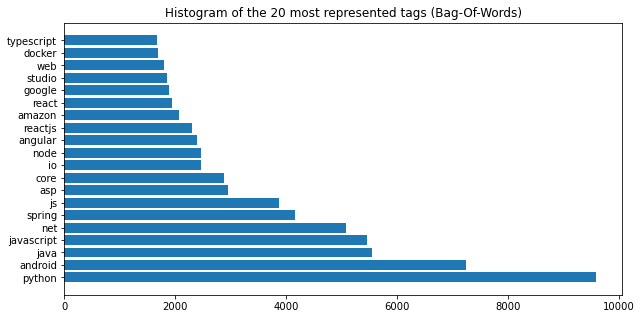

In [91]:
top_20_tags_word = df_tags_freq.sort_values("Value", ascending=False)[:20]

plt.figure(figsize=(10,5))
plt.barh(y=top_20_tags_word.index, width=top_20_tags_word.Value)
plt.title("Histogram of the 20 most represented tags (Bag-Of-Words)")
plt.show()

In [92]:
vectorizer_tf = TfidfVectorizer(max_features=2000)
tfidf_tags = vectorizer_tf.fit_transform(data['Tags T2N']).toarray()
feature_names = vectorizer_tf.get_feature_names_out()
df_tags_tf = pd.DataFrame(tfidf_tags, columns=feature_names)

df_tags_tf_freq = pd.DataFrame(df_tags_tf.sum(), columns=["Value"])
df_tags_tf_freq.sort_values(by=['Value'], inplace=True,ascending=False)

In [93]:
df_tags_tf_freq

,Value
python,1976.675877
android,1662.825082
java,1273.777683
javascript,1265.054985
net,1155.229268
...,...
devise,5.352237
lit,5.317594
oh,5.267059
completion,4.923031


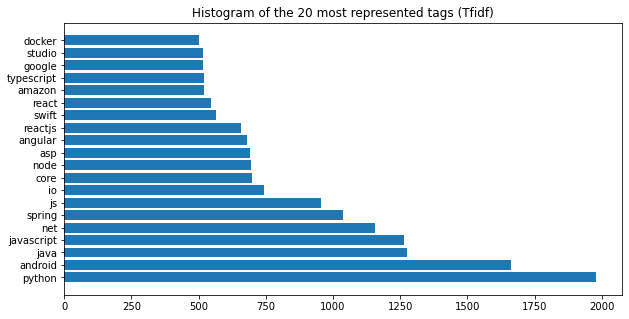

In [94]:
top_20_tags_word_tf = df_tags_tf_freq.sort_values("Value",ascending=False)[:20]

plt.figure(figsize=(10,5))
plt.barh(y=top_20_tags_word_tf.index, width=top_20_tags_word_tf.Value)
plt.title("Histogram of the 20 most represented tags (Tfidf)")
plt.show()

In [95]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [96]:
%%time
def build_word_distribution(corpus):
    """
    Build corpus word distribution
    
    Args:
        Corpus(List of lists): Original corpus
    
    Returns:
        
        word_dist_df(DataFrame): Word distribution of the corpus
    """
    
    from nltk import FreqDist
    word_corpus = [token for token_list in corpus for token in token_list]
    word_dist = FreqDist(word_corpus)
    word_dist_df = pd.DataFrame(word_dist.items(), columns=['Word', 'Frequency']).set_index('Word')
    word_dist_df.sort_values("Frequency", ascending=False, inplace=True)

    return word_dist_df

word_dist = build_word_distribution(data["Title"])

print(f"Nombre de tokens du corpus {word_dist.shape[0]}")
print("Affichage des 20 tokens les plus utilisés")
display(word_dist.head(20))

Nombre de tokens du corpus 16154
Affichage des 20 tokens les plus utilisés


,Frequency
Word,
using,3651
error,2556
file,2041
python,1904
android,1616
react,1480
function,1458
data,1333
type,1294


Wall time: 195 ms


In [97]:
tag_dist = build_word_distribution(data["Tags"])
print("Top 20 des tags les plus utilisés")
display(tag_dist.head(20))
print(f"Nombre de tags: {len(tag_dist)}")
first_200_tags = tag_dist[0:200].index.to_list()

Top 20 des tags les plus utilisés


,Frequency
Word,
python,6713
javascript,5441
java,4278
android,3629
c++,2493
io,2359
reactjs,2307
node.js,2266
angular,1665


Nombre de tags: 14430


In [98]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [99]:
data.head()

,Id,Title,Body,Tags,Title T2N,Tags T2N,Body T2N,Title_len,Body_len
0,41413141,"[client, side, still, using, interpreted, language]","[knowledge, javascript, language, execute, client, side, html, file, retrieved, server, know, ja...","[javascript, optimization, web, interpreted-language, compiled-language]",client side still using interpreted language,javascript optimization web interpreted-language compiled-language,knowledge javascript language execute client side html file retrieved server know javascript me...,6,87
1,41413489,"[coroutine, threading, context, coroutine, scheduling]","[latest, http, open, doc, paper, based, understanding, async, await, language, support, wonderin...","[c++, multithreading, async-await, coroutine, c++-coroutine]",coroutine threading context coroutine scheduling,c++ multithreading async-await coroutine c++-coroutine,latest http open doc paper based understanding async await language support wondering execution...,5,276
2,41413544,"[calculate, percentile, long, array]","[given, long, array, latency, millisecond, want, calculate, percentile, method, work, sure, veri...","[java, math, statistic, apache-commons, percentile]",calculate percentile long array,java math statistic apache-commons percentile,given long array latency millisecond want calculate percentile method work sure verify whether ...,4,62
3,41414796,"[microsoft, extension, logging, console, application, using, serilog, autofac]","[common, class, core, application, ctor, microsoft, extension, logging, ilogger, core, internal,...","[dependency-injection, asp.net-core, autofac, serilog]",microsoft extension logging console application using serilog autofac,dependency-injection asp.net-core autofac serilog,common class core application ctor microsoft extension logging ilogger core internal infrastruc...,8,34
4,41414838,"[jquery, datatable, placing, custom, loading, instead, default, processing, text]","[using, current, version, jquery, datatable, implemented, server, side, processing, place, loadi...","[javascript, jquery, ajax, datatables, datatables-1.10]",jquery datatable placing custom loading instead default processing text,javascript jquery ajax datatables datatables-1.10,using current version jquery datatable implemented server side processing place loading instead...,9,131


In [100]:
data_TF = data [["Title T2N","Tags T2N","Body T2N"]]

In [101]:
data_transform = {"Title Vectorizer" : df_title,"Title TF" : df_title_tf,
                    "Body Vectorizer" : df_body, "Body TF": df_body_tf,
                  "Tags Vectorizer" : df_tags, "Tags TF" : df_tags_tf
                 }

In [102]:
data_transform["Title Vectorizer"]

,able,absolute,abstract,accept,accepting,access,accessible,accessing,according,account,...,xlsx,xunit,yaml,yarn,year,yield,youtube,zero,zone,zoom
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42105,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
42106,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
42107,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
42108,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [103]:
data_transform["Title TF"]

,able,absolute,abstract,accept,accepting,access,accessible,accessing,according,account,...,xlsx,xunit,yaml,yarn,year,yield,youtube,zero,zone,zoom
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42105,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
42106,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
42107,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
42108,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [107]:
data

,Id,Title,Body,Tags,Title T2N,Tags T2N,Body T2N,Title_len,Body_len
0,41413141,"[client, side, still, using, interpreted, language]","[knowledge, javascript, language, execute, client, side, html, file, retrieved, server, know, ja...","[javascript, optimization, web, interpreted-language, compiled-language]",client side still using interpreted language,javascript optimization web interpreted-language compiled-language,knowledge javascript language execute client side html file retrieved server know javascript me...,6,87
1,41413489,"[coroutine, threading, context, coroutine, scheduling]","[latest, http, open, doc, paper, based, understanding, async, await, language, support, wonderin...","[c++, multithreading, async-await, coroutine, c++-coroutine]",coroutine threading context coroutine scheduling,c++ multithreading async-await coroutine c++-coroutine,latest http open doc paper based understanding async await language support wondering execution...,5,276
2,41413544,"[calculate, percentile, long, array]","[given, long, array, latency, millisecond, want, calculate, percentile, method, work, sure, veri...","[java, math, statistic, apache-commons, percentile]",calculate percentile long array,java math statistic apache-commons percentile,given long array latency millisecond want calculate percentile method work sure verify whether ...,4,62
3,41414796,"[microsoft, extension, logging, console, application, using, serilog, autofac]","[common, class, core, application, ctor, microsoft, extension, logging, ilogger, core, internal,...","[dependency-injection, asp.net-core, autofac, serilog]",microsoft extension logging console application using serilog autofac,dependency-injection asp.net-core autofac serilog,common class core application ctor microsoft extension logging ilogger core internal infrastruc...,8,34
4,41414838,"[jquery, datatable, placing, custom, loading, instead, default, processing, text]","[using, current, version, jquery, datatable, implemented, server, side, processing, place, loadi...","[javascript, jquery, ajax, datatables, datatables-1.10]",jquery datatable placing custom loading instead default processing text,javascript jquery ajax datatables datatables-1.10,using current version jquery datatable implemented server side processing place loading instead...,9,131
...,...,...,...,...,...,...,...,...,...
42105,73877384,"[different, result, compiler]","[include, iostream, main, bool, true, cout, decltype, bool, value, auto, cout, decltype, bool, v...","[c++, boolean, rvalue, lvalue, value-categories]",different result compiler,c++ boolean rvalue lvalue value-categories,include iostream main bool true cout decltype bool value auto cout decltype bool value code dif...,3,30
42106,73902642,"[office, imap, authentication, oauth, python, msal, library]","[trying, upgrade, legacy, mail, authenticate, oauth, instead, basic, authentication, deprecated,...","[python, email, oauth-2.0, office365, imap]",office imap authentication oauth python msal library,python email oauth-2.0 office365 imap,trying upgrade legacy mail authenticate oauth instead basic authentication deprecated day docum...,7,327
42107,73904491,"[valid, treat, scalar, member, struct, comprised, array]","[looking, code, dear, imgui, found, following, code, edited, relevance, struct, imvec, float, fl...","[c++, pointer, struct, undefined-behavior, strict-aliasing]",valid treat scalar member struct comprised array,c++ pointer struct undefined-behavior strict-aliasing,looking code dear imgui found following code edited relevance struct imvec float float operator...,7,35
42108,73942022,"[jenkins, deploying, latest, github, commit, code]","[trying, jenkins, deploy, latest, code, github, branch, server, push, release, branch, however, ...","[.net, jenkins, deployment, cicd]",jenkins deploying latest github commit code,.net jenkins deployment cicd,trying jenkins deploy latest code github branch server push release branch however latest commi...,6,334


# Sauvegarde dans un nouveau dataset.

In [104]:
data.to_csv("data_clean.csv") 